### Name - Ananya Goel
### Roll No - 101903073
### Group - 4CO3

#  For solving the time series prediction problem of Road sensor dataset using Light Gradient Boosting Machine

## Declaration and Preprocessing

In [27]:
# Import Section
import pandas as pd
import numpy as np
import random
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
import warnings
from collections import defaultdict
from lightgbm import LGBMRegressor

In [28]:
warnings.filterwarnings("ignore")

In [29]:
# Read and print the excel file
dataf = pd.read_excel('ROAD_DATA.xlsx')

In [30]:
# Print the dataset
dataf.head()

,Unnamed: 0,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.52
1,NaN,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.62
2,NaN,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.68
3,NaN,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.78
4,NaN,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.80


In [31]:
# Remove anomolies of sections
clear_idx = 910
lst_to_clear = []
for i in range(9):
  lst_to_clear.append(clear_idx+i)
lst_to_clear
dataf.fillna(0, inplace=True)
dataf.drop(lst_to_clear, inplace = True)

In [32]:
# Rename column to section_name
dataf.columns = dataf.columns.str.replace('Unnamed: 0', 'Section')

In [33]:
# Naming sections 
mul = 10
j = 0
for i in range(100):
  sec_name = dataf.iloc[j,0]
  dataf.iloc[j:j + mul, 0] = sec_name
  j += mul
test_frame = dataf.loc[dataf['year'] == 10]
dataf.head()

,Section,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.52
1,Sec_1,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.62
2,Sec_1,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.68
3,Sec_1,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.78
4,Sec_1,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.80


# Training and Testing - Define the Light Gradient Boosting Machine

In [34]:
model = LGBMRegressor(random_state=19)

## Extract the test and training dataset for each section

In [35]:
# Extract the training part of input dataset
o = 9
def e_xtrain(dataf, rowstart, colstart):
  row_end = rowstart + o
  return dataf.iloc[rowstart:row_end, 1:10]

In [36]:
# Extract the training part of output dataset
def e_ytrain(dataf, rowstart, colstart):
  row_end = rowstart + o
  return dataf.iloc[rowstart:row_end, colstart]

In [37]:
# Extract the testing part of input dataset
def e_xtest(dataf, rowstart):
  row_end = rowstart + o
  return dataf.iloc[row_end, 1:10].to_numpy()

In [38]:
# Extract the output part of ouput dataset
def e_ytest(dataf, rowstart, colstart):
  row_end = rowstart + o
  return dataf.iloc[row_end, colstart]

In [39]:
# function to calcuate mean square error
def cal_lmse(predict_val, test_val):
  pred_diff = predict_val - test_val
  return (pred_diff)**2

In [40]:
# Get the XY Split
column_name = ["Para-"+str(i) for i in range(9,14)]
XY = []
def getXYsplit(dataf, rowstart, row_end):
  XY = []
  XY.append(e_xtrain(dataf, rowstart, row_end))
  XY.append(e_ytrain(dataf, rowstart, row_end))
  XY.append(e_xtest(dataf,rowstart))
  XY.append(e_ytest(dataf,rowstart,row_end))
  return XY

In [41]:
# Create a dictionary for storing predicted and true values
pred_values = defaultdict(lambda : [])

In [42]:
from sklearn.metrics import mean_squared_error

In [43]:
coltarget = [10,11,12,13,14]
rmse = []
totalcount = 0
currsection = 0
total_squarederror = 0
maxval = 1000
for j in coltarget:
  local_squared_error = 0
  l_count = 0
  LXY = [0,0,0,0]
  for i in range(0, maxval, 10):
    LXY = getXYsplit(dataf,i,j)
    x_train, y_train,x_test,y_test = LXY[0],LXY[1],LXY[2],LXY[3]

    # fit the model and predict
    model.fit(x_train, y_train)
    ypred = model.predict(x_test.reshape(1,-1))[0]

    # store the predicted values
    pred_values[column_name[currsection]].append(ypred)
    
    # store squared difference for RMSE

    # local_squared_error = calcuate_lmse(ypred, y_test) + local_squared_error
    total_squarederror = cal_lmse(ypred, y_test) + total_squarederror
    l_count += 1
    totalcount += 1

  # root_mean_square_error.append(local_squared_error)
  currsection += 1
predicted_df = pd.DataFrame.from_dict(pred_values)

In [44]:
# Calculate  RMSE
total_rmse_by_n = total_squarederror/totalcount
final_rmse = total_rmse_by_n**0.5

print("The RMSE is " + str(final_rmse))

The RMSE is 68.76256275509705


# Plot

In [45]:
dataf

,Section,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.520
1,Sec_1,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.620
2,Sec_1,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.680
3,Sec_1,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.780
4,Sec_1,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,Sec_101,6,454.0,931.8,13.6,125.0,13,116,4150,830,15.1,1.8,1.0,15,1.681
1005,Sec_101,7,454.0,703.0,14.5,17.0,13,118,4150,830,24.6,7.9,2.0,15,1.838
1006,Sec_101,8,454.0,1124.1,14.9,45.0,18,117,4200,840,119.0,15.7,2.0,16,1.862
1007,Sec_101,9,454.0,1462.3,13.2,62.0,27,117,4400,720,138.2,30.5,6.0,18,1.883


In [46]:
# Get random rows for plotting
plot_row = 40

random_rows = []
for i in range(plot_row):
  random_rows.append(random.randint(0,90))


## Plot for 9th para

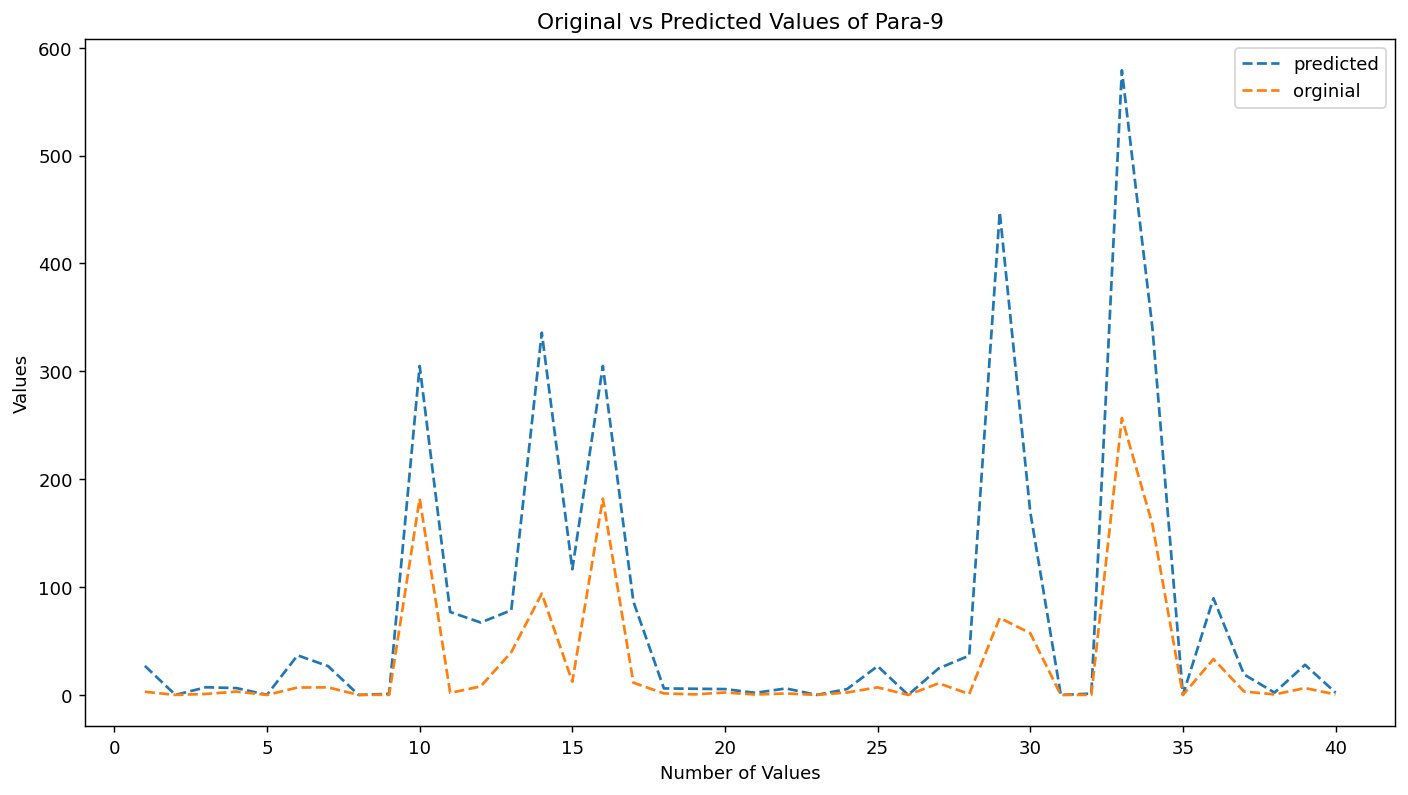

In [47]:
figure(figsize=(13, 7), dpi=130)
tv = predicted_df.iloc[random_rows, 0]
pv = test_frame.iloc[random_rows,10]
x_value = []
for i in range(len(tv)):
  x_value.append(i+1)
plt.plot(x_value,pv, linestyle = 'dashed', label = 'predicted')
plt.plot(x_value,tv, linestyle = 'dashed', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('Original vs Predicted Values of Para-9')
plt.legend(loc = 'upper right')

## Plot for 10th para

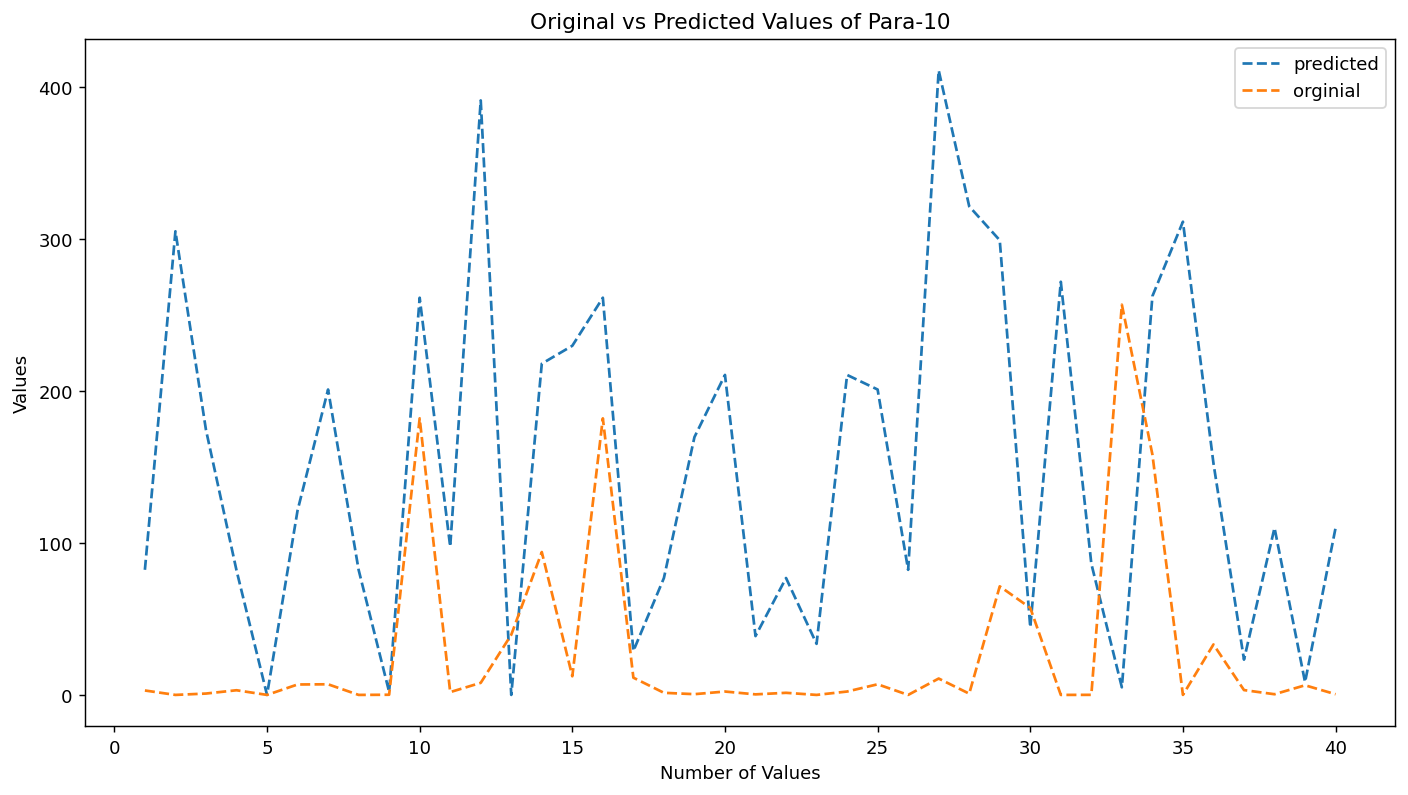

In [48]:
figure(figsize=(13, 7), dpi=130)
tv = predicted_df.iloc[random_rows, 0]
pv = test_frame.iloc[random_rows,11]
x_value = []
for i in range(len(tv)):
  x_value.append(i+1)
plt.plot(x_value,pv, linestyle = 'dashed', label = 'predicted')
plt.plot(x_value,tv, linestyle = 'dashed', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('Original vs Predicted Values of Para-10')
plt.legend(loc = 'upper right')

## Plot for 11th para

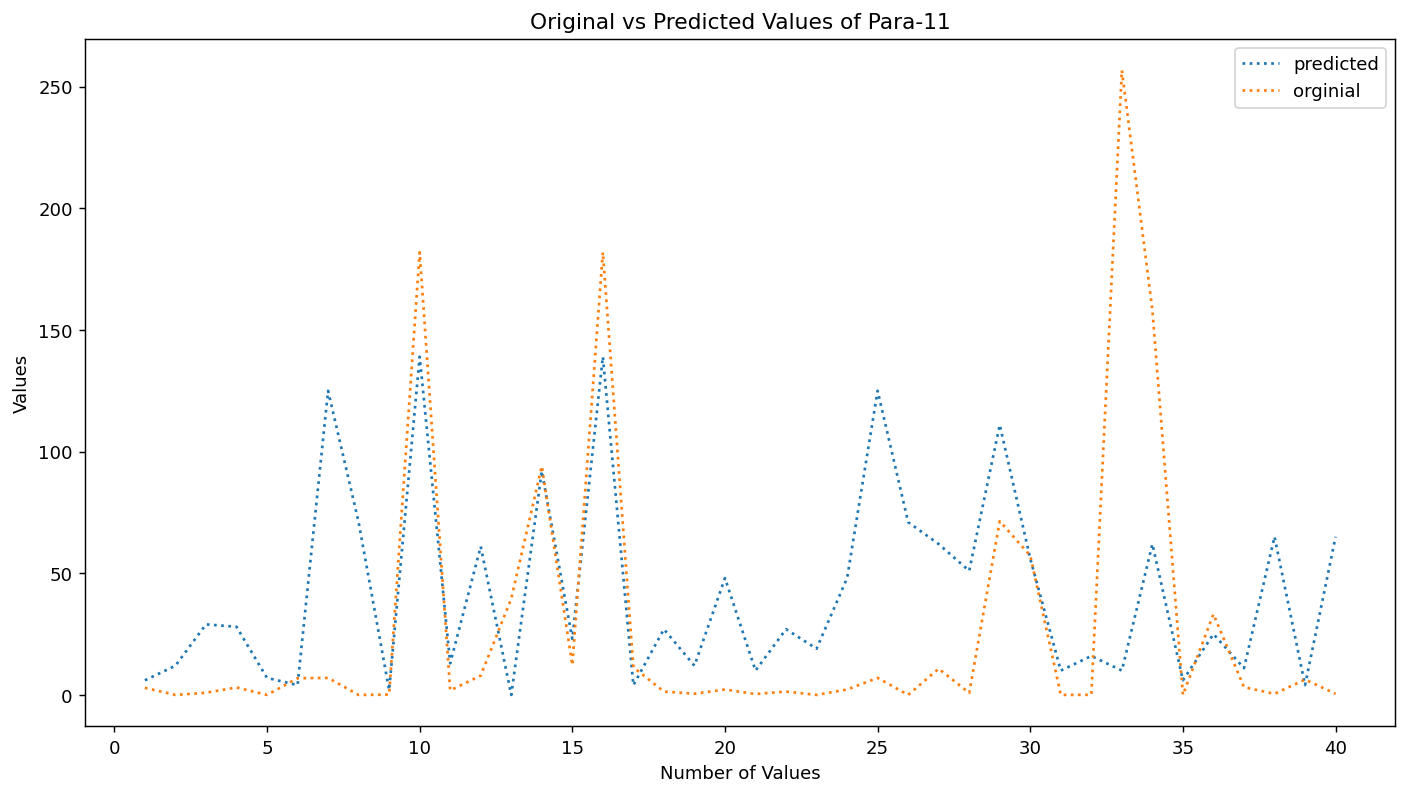

In [49]:
figure(figsize=(13, 7), dpi=130)
tv = predicted_df.iloc[random_rows, 0]
pv = test_frame.iloc[random_rows,12]
x_value = []
for i in range(len(tv)):
  x_value.append(i+1)
plt.plot(x_value,pv, linestyle = 'dotted', label = 'predicted')
plt.plot(x_value,tv, linestyle = 'dotted', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('Original vs Predicted Values of Para-11')
plt.legend(loc = 'upper right')

## Plot for 12th para

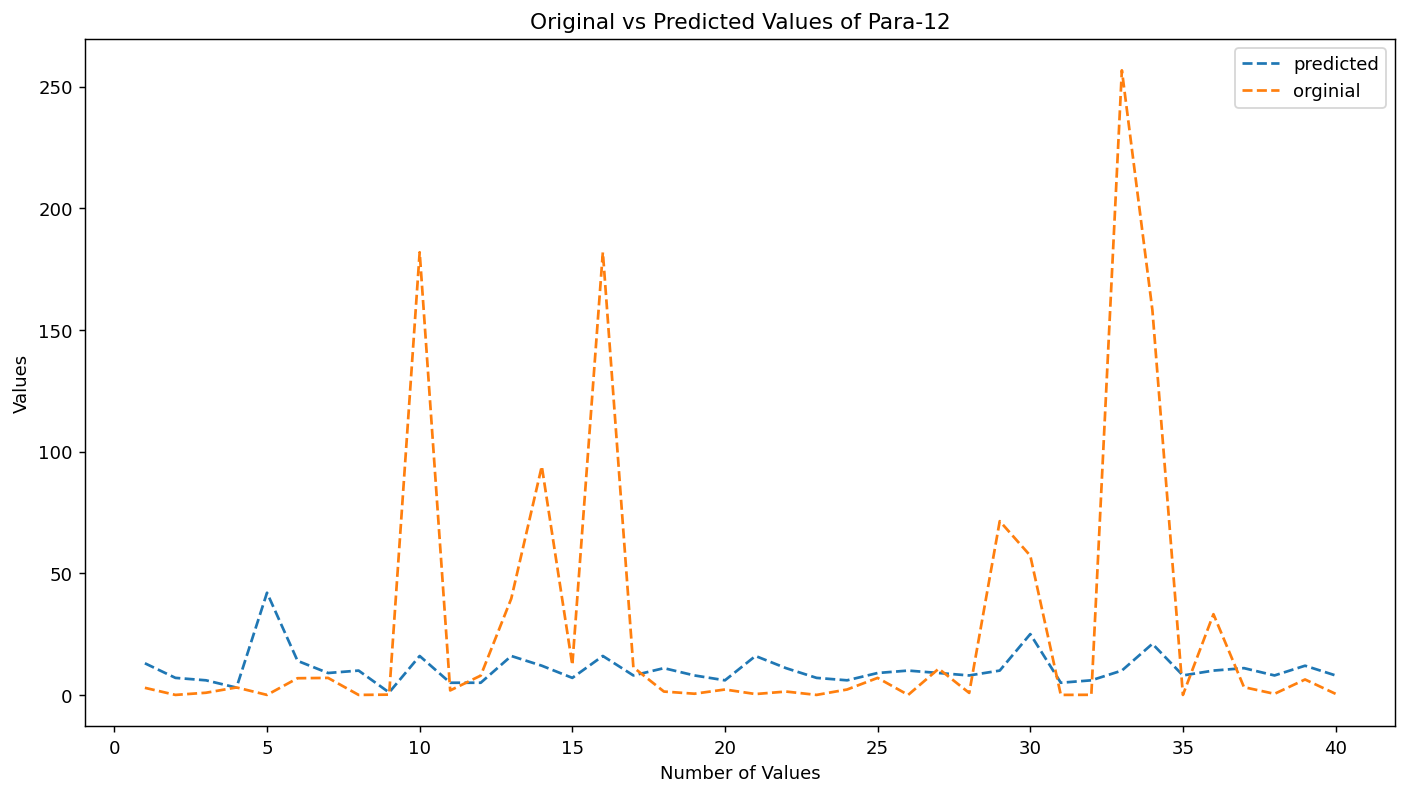

In [50]:
figure(figsize=(13, 7), dpi=130)
tv = predicted_df.iloc[random_rows, 0]
pv = test_frame.iloc[random_rows,13]
x_value = []
for i in range(len(tv)):
  x_value.append(i+1)
plt.plot(x_value,pv, linestyle = 'dashed', label = 'predicted')
plt.plot(x_value,tv, linestyle = 'dashed', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('Original vs Predicted Values of Para-12')
plt.legend(loc = 'upper right')

## Plot for 13th para


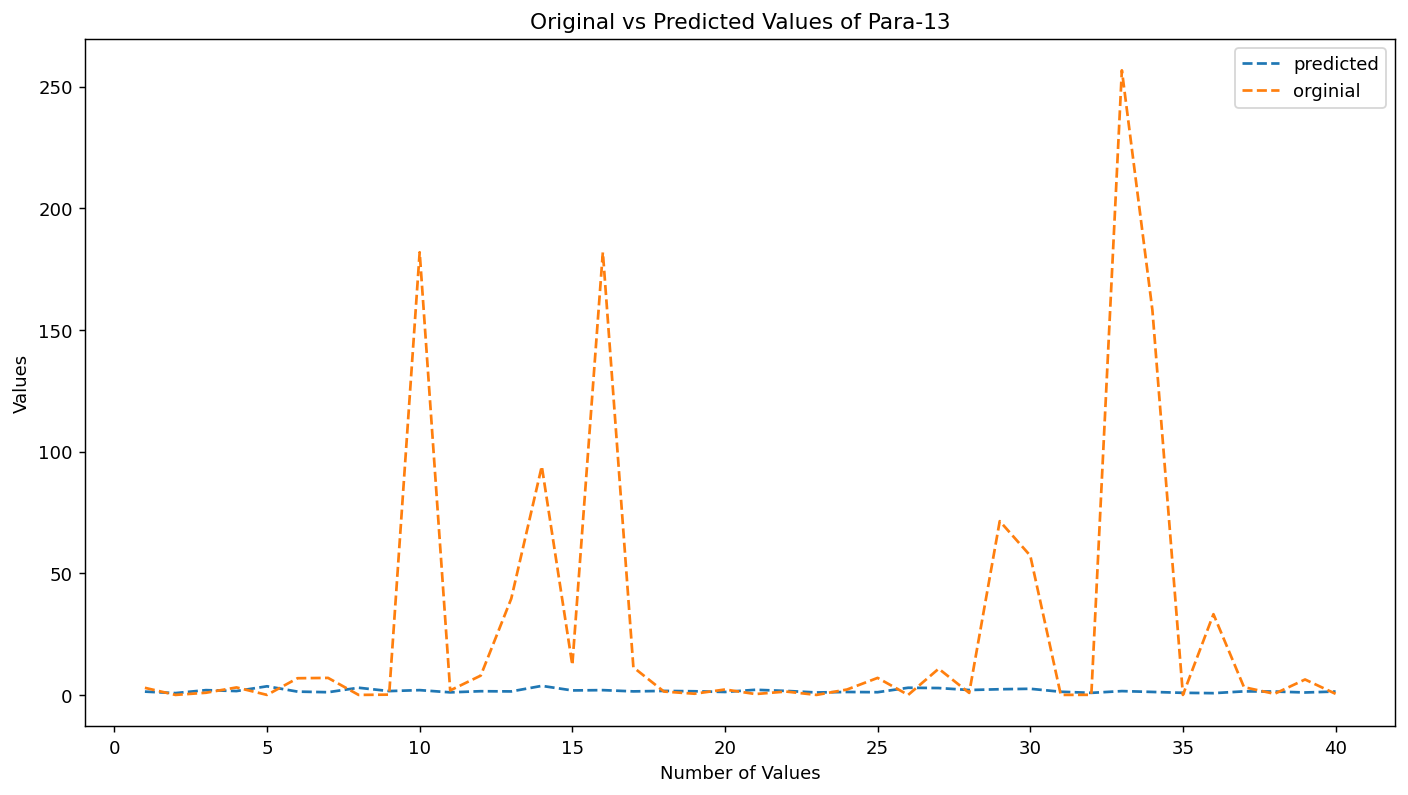

In [51]:
figure(figsize=(13, 7), dpi=130)
tv = predicted_df.iloc[random_rows, 0]
pv = test_frame.iloc[random_rows,14]
x_value = []
for i in range(len(tv)):
  x_value.append(i+1)
plt.plot(x_value,pv, linestyle = 'dashed', label = 'predicted')
plt.plot(x_value,tv, linestyle = 'dashed', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('Original vs Predicted Values of Para-13')
plt.legend(loc = 'upper right')